# Regressione multipla e selezione delle variabili

## Regressione su dati continui

- Abbiamo un dataset contenente attributi di 1057 abitazioni.
- Siamo interessati a spiegare il prezzo in funzione di covariate quali l'area soggiorno, il numero di stanze da letto, il numero di bagni, il numero di camini, l'età della casa (da quanti anni è stata costruita).
- **Steps**:

    - Verifica della distribuzione della variabile di risposta ed eventuale trasformazione
    - Fit del odello di regressione multipla
    - Rapide diagnostiche di verifica delle assunzioni ed eventuali "correzioni"
    - Intepretazione degli effetti
    
## Selezione variabili

- Potrebbe essere fatta una selezione dei predittori da utilizzare per il modello di regressione?
- Esempio di una procedura *step--wise* di tipo *backward*.

## Regressione su dati continui

In [1]:
%pylab inline

import pandas as pd
import seaborn as sb
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


/Users/davidepassaretti/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_df = pd.read_csv('HousingPrices2010.csv')

In [3]:
my_df.head()

,Price,Living.Area,Bedrooms,Bathrooms,Fireplaces,Age
0,142212,1982,3,1.0,0,133
1,134865,1676,3,1.5,1,14
2,118007,1694,3,2.0,1,15
3,138297,1800,2,1.0,2,49
4,129470,2088,3,1.0,1,29


In [4]:
y = my_df['Price']
x = my_df.drop('Price', 1)
x['constant'] = 1

(array([  17.,  101.,  289.,  236.,  172.,  114.,   60.,   26.,   18.,
           9.,    1.,    7.,    4.,    0.,    3.]),
 array([  16858. ,   55714.2,   94570.4,  133426.6,  172282.8,  211139. ,
         249995.2,  288851.4,  327707.6,  366563.8,  405420. ,  444276.2,
         483132.4,  521988.6,  560844.8,  599701. ]),
 <a list of 15 Patch objects>)

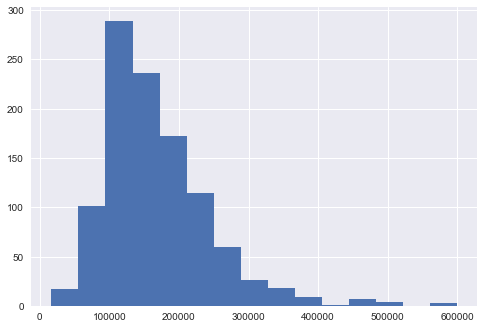

In [5]:
plt.hist(y, 15)

La variabile di risposta è decisamente asimmetrica. Potremmo già intervenire portandola su scala logaritmica.

(array([   1.,    2.,    1.,    1.,   12.,   23.,   48.,  181.,  203.,
         223.,  180.,  115.,   45.,   12.,   10.]),
 array([  9.7325806 ,   9.97068766,  10.20879472,  10.44690178,
         10.68500883,  10.92311589,  11.16122295,  11.39933001,
         11.63743707,  11.87554413,  12.11365118,  12.35175824,
         12.5898653 ,  12.82797236,  13.06607942,  13.30418648]),
 <a list of 15 Patch objects>)

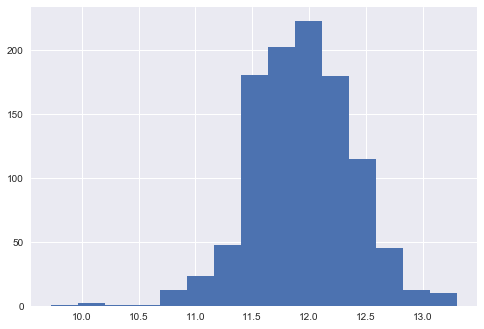

In [6]:
plt.hist(log(y), 15)

Eseguiremo una trasformazione logaritmica della variabile Prezzo, pratica molto frequente in Econometria.

In [7]:
log_y = log(y)
log_y.name = 'Log.Price'
model = sm.OLS(log_y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log.Price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     316.3
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          1.15e-206
Time:                        09:28:50   Log-Likelihood:                -150.09
No. Observations:                1057   AIC:                             312.2
Df Residuals:                    1051   BIC:                             342.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Living.Area     0.0003   2.31e-05     14.007      0.000       0.000       0.000
Bedrooms        0.0098      0.016      0.623      0.534      -0.021       0.041
Bathrooms       0.1266      0.021      5.998      0.000       0.085       0.168
Fireplaces      0.0899      0.018      4.893      0.000       0.054       0.126
Age            -0.0020      0.000     -7.257      0.000      -0.003      -0.001
constant       11.0724      0.042    263.241      0.000      10.990      11.155
==============================================================================
Omnibus:                      133.423   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1325.471
Skew:                          -0.065   Prob(JB):                    1.51e-288
Kurtosis:                       8.484   Cond. No.                     9.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Seppure l'ipotesi di normalità dei residui non sembra essere verificata, l'inferenza parametrica sui coefficienti è ancora possibile in quanto la numerosità campionaria è abbastanza ampia da poter sfruttare il _Teorema del Limite Centrale_.**

### Test per l'assunzione di linearità

Il Tuckey test di additività verifica se vi sia un pattern nei residui contro valori predetti. Per far ciò, aggiunge come ulteriore predittore della regressione stimata i valori predetti al quadrato. Nel caso tale predittore sia significativo, rifiutiamo l'ipotesi di linerità.

In [8]:
xtests = x.copy()

xtests['fv2'] = model.fittedvalues**2
sm.OLS(log_y, xtests).fit().pvalues[6]

0.57385851289285039

### Verifica dell'assunzione di non collinearità tra predittori (VIF)

Il *Variance Inflation Factor* **(VIF)** fornisce uno score di quanto correlato sia un determinato predittore con tutti gli altri. Per far ciò, si calcola il reciproco del complemento a 1 del valore dell'R quadro calcolato sulla regressione avente come variabile di risposta il predittore in questione e come variabili indipendenti i predittori restanti. Un **VIF** superiore a 5 è già un campanello di allarme, superiore a 10 è critico.

In [9]:
# VIF Living.Area
print {'Predittore':'Living.Area', 'VIF' : 1 / (1 - sm.OLS(x['Living.Area'], x.drop('Living.Area', 1)).fit().rsquared)}

# VIF Bedrooms
print {'Predittore':'Bedrooms', 'VIF' : 1 / (1 - sm.OLS(x['Bedrooms'], x.drop('Bedrooms', 1)).fit().rsquared)}

# VIF Bathrooms
print {'Predittore':'Bathrooms', 'VIF' : 1 / (1 - sm.OLS(x['Bathrooms'], x.drop('Bathrooms', 1)).fit().rsquared)}

# VIF Fireplaces
print {'Predittore':'Fireplaces', 'VIF' : 1 / (1 - sm.OLS(x['Fireplaces'], x.drop('Fireplaces', 1)).fit().rsquared)}

# VIF Age
print {'Predittore':'Age', 'VIF' : 1 / (1 - sm.OLS(x['Age'], x.drop('Age', 1)).fit().rsquared)}

{'Predittore': 'Living.Area', 'VIF': 3.1557323307004839}
{'Predittore': 'Bedrooms', 'VIF': 1.8520320399733798}
{'Predittore': 'Bathrooms', 'VIF': 2.5423733748266488}
{'Predittore': 'Fireplaces', 'VIF': 1.3809459885146618}
{'Predittore': 'Age', 'VIF': 1.2703372801618498}


### Ricerca di punti influenti

Più che gli outliers (punti che hanno valori della variabile di risposta molto lontani dalla media), siamo interessati ai punti con un'alta *leverage*, cioè quei punti che influenzano criticamente le stime dei parametri. Per verificare se siano presenti, possiamo avvalerci della **Cook's distance**, ovvero una misura di distanza tra le stime ottenute includendo una determinata osservazione e quelle ottenute escludendola. I punti per cui tale distanza è maggiore di 1 sono critici. Verifichiamo la percentuale di punti che abbiano un valore di **Cook's distance** inferiore a 1 (vorremmo che sia il 100%).

In [10]:
np.mean(model.get_influence().cooks_distance[0] < 1) * 100

100.0

### Test per l'assunzione di omoschedasticità

Il test più completo per la verifica dell'omoschedasticità è quello di White (per certi versi migliore del noto test di Breusch-Pagan). Il test consiste nello stimare una regressione ausiliaria usando come variabile di risposta i residui quadratici del modello e come due variabili esplicative i valori predetti ed i valori predetti al quadrato: nel caso il test sulla bontà della regressione ausiliaria sia significativo, l'ipotesi nulla di omoschedasticità è rifiutata.

In [11]:
# creo la variabile di risposta (residui al quadrato)
res2 = model.resid**2

# predittori
df_fv = pd.DataFrame({ 'fv' : model.fittedvalues, 'fv2' : model.fittedvalues**2 })

# ottengo il p-value del test
sm.OLS(res2, df_fv).fit().f_pvalue

1.8320307383285534e-34

**Dato che vi è eteroschedasticità, possiamo usare la correzione di White per ottenere standard errors e p-values.**

### Re-fit del modello con correzione di White ed interpretazione dei coefficienti

In [12]:
sm.OLS(log_y, x).fit(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log.Price   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     276.4
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          1.03e-188
Time:                        09:28:51   Log-Likelihood:                -150.09
No. Observations:                1057   AIC:                             312.2
Df Residuals:                    1051   BIC:                             342.0
Df Model:                           5                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Living.Area     0.0003   2.93e-05     11.027      0.000       0.000       0.000
Bedrooms        0.0098      0.018      0.544      0.587      -0.026       0.045
Bathrooms       0.1266      0.024      5.318      0.000       0.080       0.173
Fireplaces      0.0899      0.020      4.559      0.000       0.051       0.129
Age            -0.0020      0.001     -3.991      0.000      -0.003      -0.001
constant       11.0724      0.049    226.684      0.000      10.977      11.168
==============================================================================
Omnibus:                      133.423   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1325.471
Skew:                          -0.065   Prob(JB):                    1.51e-288
Kurtosis:                       8.484   Cond. No.                     9.89e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 9.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Iniziamo con il ricordare che la variabile di risposta (il prezzo) è espressa su scala logaritmica, quindi l'interpretazione su scala originaria farà riferimento ad un modello log-lineare.

**_Avendo a che fare con una regressione multipla, la relazione tra un determinato predittore e la variabile di risposta va interpretata tenendo costanti i restanti predittori._**

La costante  è difficilmente interpretabile, seppure risulti significativamente diversa da zero: 11.07 dovrebbe essere il logaritmo del prezzo di una casa nuova (**Age** = 0) nel caso in cui non vi sia un'area soggiorno, né bagni, né camere da letto, né camini. Esiste una casa così?

La variabile **Bedrooms**, la quale conta il numero di camere da letto, non ha un effetto significativo sulla variazione di prezzo, mantenendo costanti gli altri predittori.

La variabile **Living.Area**, la quale esprime il numero di piedi quadrati dell'area soggiorno, ha un effetto positivo sul prezzo: ad un aumento di un piede quadro del soggiorno corrisponde un aumento medio di 0.0003 del logaritmo del prezzo. Sulla scala iniziale, ciò vale a dire che un per un aumento di un piede quadro il prezzo aumenta in media di un fattore pari a exp(0.0003) = 1.0003, cioè dello 0.3%.

La variabile **Bathrooms**, la quale esprime il numero di bagni, ha un effetto positivo sul prezzo: ad un bagno in più corrisponde un aumento medio di 0.1266 del logaritmo del prezzo. Sulla scala iniziale, ciò vale a dire che un per un bagno in più il prezzo aumenta in media di un fattore pari a exp(0.1266) = 1.1350, cioè del 13.50%.

La variabile **Fireplaces**, la quale esprime il numero di camini, ha un effetto positivo sul prezzo: ad un camino in più corrisponde un aumento medio di 0.0899 del logaritmo del prezzo. Sulla scala iniziale, ciò vale a dire che un per un camino in più il prezzo aumenta in media di un fattore pari a exp(0.0899) = 1.0941, cioè del 9.41%.

La variabile **Age**, la quale esprime l'età in anni della casa, ha un effetto negativo sul prezzo: ad un anno in più corrisponde un decremento medio di 0.0020 del logaritmo del prezzo. Sulla scala iniziale, ciò vale a dire che un per un anno in più il prezzo diminuisce in media di un fattore pari a exp(-0.0020) = 0.9980, cioè dello 0.20%.

## Backward step-wise variable selection

### Funzione

In [13]:
def backward(y, x):
    
    bic_ = sm.OLS(y, x).fit().bic
    da_eliminare = ''
    
    for nome in x.columns:
        x_sub = x.drop(nome, 1)
        bic_nuovo = sm.OLS(y, x_sub).fit().bic
        if bic_nuovo < bic_:
            bic_ = bic_nuovo
            da_eliminare = nome
            
    return {'Predittore da scartare': da_eliminare}

### Step 1

In [14]:
backward(log_y, x)

{'Predittore da scartare': 'Bedrooms'}

### Step 2

In [15]:
backward(log_y, x.drop('Bedrooms', 1))

{'Predittore da scartare': ''}